Step 1: Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error


 Step 2: Load and Preprocess Data

In [9]:
data = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False, na_values=['?'])
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
data = data[['DateTime', 'Global_active_power']]
data = data.dropna()
data = data.set_index('DateTime')
data = data.astype({'Global_active_power':'float'})


Step 3: Resample Data (Hourly)



In [10]:
data_hourly = data.resample('H').mean()
data_hourly = data_hourly.dropna()
data_hourly.head()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6552\4057849942.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_hourly = data.resample('H').mean()


,Global_active_power
DateTime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


Step 4: Plot the Data

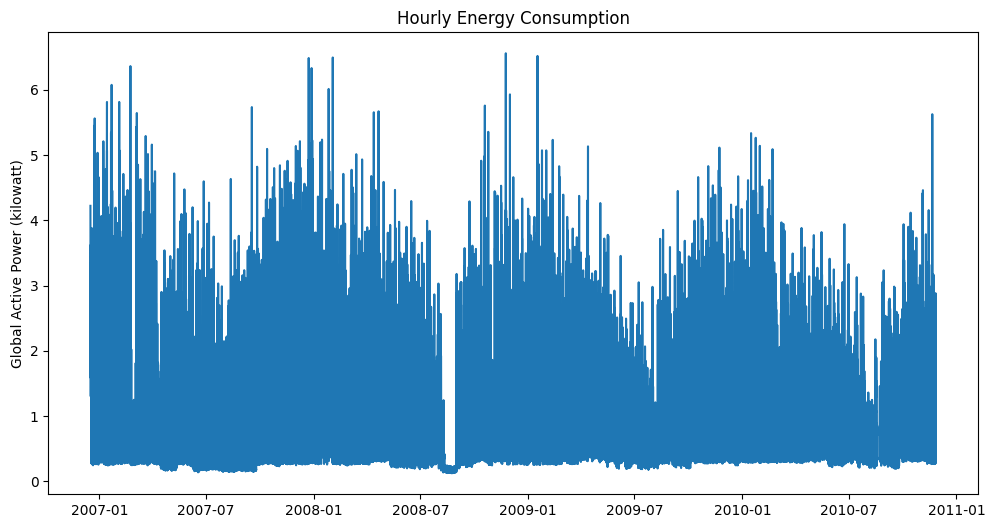

In [11]:
plt.figure(figsize=(12,6))
plt.plot(data_hourly.index, data_hourly['Global_active_power'])
plt.title('Hourly Energy Consumption')
plt.ylabel('Global Active Power (kilowatt)')
plt.show()


Step 5: Train-Test Split

In [12]:
train_size = int(len(data_hourly) * 0.8)
train, test = data_hourly.iloc[:train_size], data_hourly.iloc[train_size:]
print(f"Train shape: {train.shape}, Test shape: {test.shape}")


Train shape: (27334, 1), Test shape: (6834, 1)


Step 6: ARIMA Model

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Fit ARIMA
model_arima = ARIMA(train, order=(2,1,2))
model_arima_fit = model_arima.fit()

# Forecast
forecast_arima = model_arima_fit.forecast(steps=len(test))

# Evaluation
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
print(f"ARIMA MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}")


c:\Users\Administrator\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Administrator\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st

ARIMA MAE: 0.811, RMSE: 0.935


c:\Users\Administrator\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Administrator\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Step 7: Prophet Model

In [18]:
from prophet import Prophet

# Prepare DataFrame
df_prophet = train.reset_index().rename(columns={'DateTime':'ds', 'Global_active_power':'y'})

# Fit Prophet
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(df_prophet)

# Forecast Future
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast_prophet = model_prophet.predict(future)
forecast_values = forecast_prophet.iloc[-len(test):]['yhat'].values

# Evaluation
mae_prophet = mean_absolute_error(test, forecast_values)
rmse_prophet = np.sqrt(mean_squared_error(test, forecast_values))
print(f"Prophet MAE: {mae_prophet:.3f}, RMSE: {rmse_prophet:.3f}")


20:59:44 - cmdstanpy - INFO - Chain [1] start processing
20:59:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Administrator\miniconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet MAE: 0.655, RMSE: 0.821


Step 8: XGBoost Model

In [19]:
import xgboost as xgb

# Feature Engineering
df_xgb = data_hourly.copy()
df_xgb['hour'] = df_xgb.index.hour
df_xgb['dayofweek'] = df_xgb.index.dayofweek

X = df_xgb[['hour', 'dayofweek']].values
y = df_xgb['Global_active_power'].values

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)

# Prediction and Evaluation
y_pred_xgb = model_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost MAE: {mae_xgb:.3f}, RMSE: {rmse_xgb:.3f}")


XGBoost MAE: 0.499, RMSE: 0.667


Step 9: Visualization

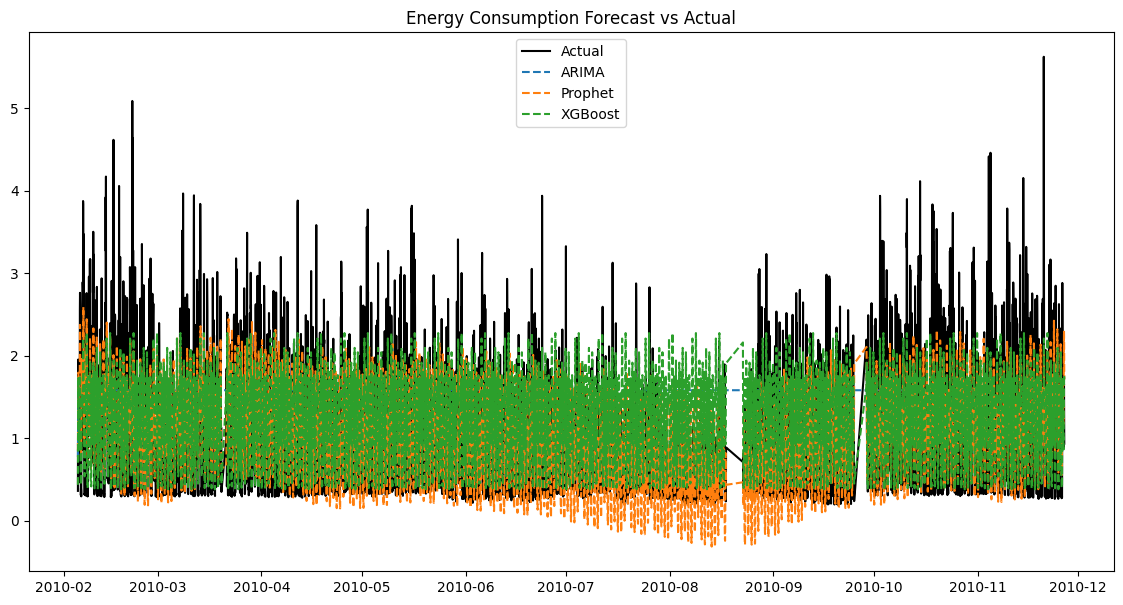

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(test.index, test.values, label='Actual', color='black')
plt.plot(test.index, forecast_arima, label='ARIMA', linestyle='--')
plt.plot(test.index, forecast_values, label='Prophet', linestyle='--')
plt.plot(test.index, y_pred_xgb, label='XGBoost', linestyle='--')
plt.legend()
plt.title('Energy Consumption Forecast vs Actual')
plt.show()


Step 10: Summary Table

In [21]:
print("\nSummary of Results:")
print(f"ARIMA → MAE: {mae_arima:.3f}, RMSE: {rmse_arima:.3f}")
print(f"Prophet → MAE: {mae_prophet:.3f}, RMSE: {rmse_prophet:.3f}")
print(f"XGBoost → MAE: {mae_xgb:.3f}, RMSE: {rmse_xgb:.3f}")



Summary of Results:
ARIMA → MAE: 0.811, RMSE: 0.935
Prophet → MAE: 0.655, RMSE: 0.821
XGBoost → MAE: 0.499, RMSE: 0.667
